# MSA 2025 Phase 2 - Part 2: Minimum Temperature Prediction from Weather Data

## 1. Load and check the dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# load the dataset
# avoid DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.

df = pd.read_csv('Summary of Weather.csv', low_memory=False)

print('first 5 rows of the dataset:')
display(df.head())
print('all columns in the dataset:')
print(df.columns.tolist())
print('info of the dataset:')
df.info()

first 5 rows of the dataset:


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


all columns in the dataset:
['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
info of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           11904

## 2. Clean the dataset, drop variables

In [6]:
# delete columns with all NaN values
nan_cols = [col for col in df.columns if df[col].isnull().all()]
df = df.drop(columns=nan_cols)

# 2. delete columns with high missing values(>95%)
missing_ratio = df.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.95].index.tolist()
df = df.drop(columns=high_missing_cols)

# transform object columns that should be numeric
for col in ['Precip', 'Snowfall', 'PRCP', 'SNF']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# display remaining features and missing values
print('remaining features after cleaning:')
print(df.columns.tolist())
print('sum of missing values in each column:')
print(df.isnull().sum())

# calculate the correlation of numeric features with MinTemp
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'MinTemp' in numeric_cols:
    corr = df[numeric_cols].corr()['MinTemp'].sort_values(ascending=False)
    print('correlation with MinTemp:')
    print(corr)
else:
    print('MinTemp is not in numeric features')

remaining features after cleaning:
['STA', 'Date', 'Precip', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'MAX', 'MIN', 'MEA', 'SNF', 'TSHDSBRSGF']
sum of missing values in each column:
STA                0
Date               0
Precip         16753
MaxTemp            0
MinTemp            0
MeanTemp           0
Snowfall        1207
PoorWeather    84803
YR                 0
MO                 0
DA                 0
PRCP           18685
MAX              474
MIN              468
MEA              498
SNF             1207
TSHDSBRSGF     84803
dtype: int64
correlation with MinTemp:
MinTemp     1.000000
MIN         1.000000
MEA         0.966441
MeanTemp    0.965425
MaxTemp     0.878384
MAX         0.872096
Precip      0.098579
PRCP        0.097451
MO          0.069078
STA         0.059319
DA         -0.002576
YR         -0.020733
Snowfall   -0.320022
SNF        -0.320022
Name: MinTemp, dtype: float64


## 3. Select the feature(s) for the model, and explain the reason

In [8]:
# MIN, MEA and MeanTemp are all highly correlated with MinTemp, but MIN/MEA are almost the same as MinTemp/MeanTemp, so they should not be selected because of the possible data leak. MaxTemp and MAX are highly correlated to MinTemp too, but use both of them may lead to replication, so we only select MaxTemp. Precip and PRCP are not highly correlated with Mintemp, and they are pretty similar, so only Precip is selected because it is higher in value. So does Snowfall and SNF, Snowfall selected. YR, MO, and DA are selected no matter how the correlations are because they are time features.

selected_features = ['MaxTemp', 'Precip', 'Snowfall', 'YR', 'MO', 'DA']
print('Selected features for modeling:', selected_features)

Selected features for modeling: ['MaxTemp', 'Precip', 'Snowfall', 'YR', 'MO', 'DA']


## 4. Split the dataset (80% for training, 20% for testing)

In [9]:
# Drop rows with missing values in selected features or target
model_data = df[selected_features + ['MinTemp']].dropna()
X = model_data[selected_features]
y = model_data['MinTemp']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (81087, 6)
Test set shape: (20272, 6)


## 5. Choose the algorithm, train and test the model

In [14]:
# We use Linear Regression for this regression task
from sklearn.linear_model import LinearRegression

# Instantiate the model
reg = LinearRegression()
# Fit the model on the training data
reg.fit(X_train, y_train)
# Predict on the test set
y_pred = reg.predict(X_test)

## 6. Evaluate and Visualize model Performance

R^2: 0.7609
RMSE: 3.9642


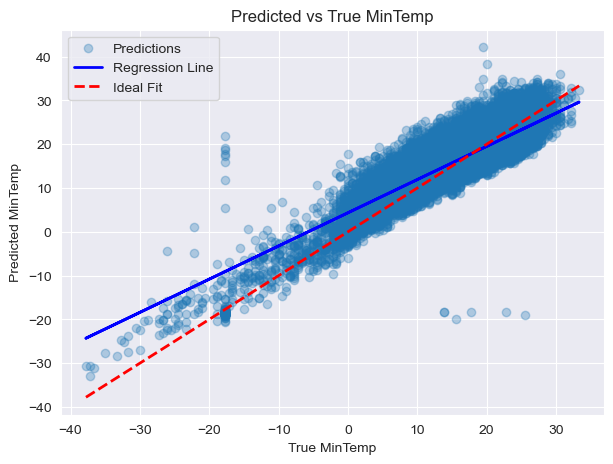

In [19]:
# Calculate R^2 and RMSE
r2 = r2_score(y_test, y_pred)

# For older versions of scikit-learn, use np.sqrt on mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

# Plot predicted vs true values with regression line and ideal fit
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.3, label='Predictions')

# Fit a regression line to the predictions
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'b-', lw=2, label='Regression Line')

# Plot the ideal fit line (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('True MinTemp')
plt.ylabel('Predicted MinTemp')
plt.title('Predicted vs True MinTemp')
plt.legend()
plt.show()


## 7. What is the R² value and RMSE of the model? How these values indicate the model performance?

In [ ]:
# R^2: 0.7609
# RMSE: 3.9642


# R^2 is used to measure how the model is fitted with the dataset, the closer to 1, the fitter the model.A 0.7609 means the model can predict about 76% of the variance of the feature.
#
# RMSE is the mean of the prediction error, the smaller the value, the better the performance.A 3.9642 means on average the prediction values will have a difference of 3.96 in value with the actual ones.

## 8. Discuss the model performance based on the plot

In [ ]:
# We can see from the plot that most points are close to the upper part of the regression line, and it seems to be symmetric on both sides of the regression line.The points are tense and close to the line, so the performance of the model is pretty good in general.But there are still some outliers in the temperature range 10 to 30 and around -20, meaning that the model cannot capture all the features in the data set.Moreover, since the ideal fit line is separated from the regression line, this also indicates the model performance is perfect, and the points are not distributed around the ideal fit line symmetrically, too.So there are small bias in the model although the model performance is well.A simple way the improve the performance might be adding more features to the model, or we can use a non-linear model instead.